# Imports

In [1]:
import sys
sys.path.append('../src')

from data_manager import build_classification_dataset
from feature_manager import feature_from_images_pipeline

import os
import random 

import matplotlib.pyplot as plt
import pandas as pd

import pickle

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

data_path = '../data'

train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

H, W, C = 720, 1280, 3
N = 2020
vertical_bounds = [200, 550]

# Dataset for vehicle recognition

In [2]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))

print(f"Training data {len(train_df)}")
train_df.head(3)

Training data 2020


,frame_id,bounding_boxes
0,train/A_001.jpg,0 225 214 317 0 172 345 254 285 240 155 131 70...
1,train/A_002.jpg,0 254 190 293 0 169 338 271 276 238 160 137 70...
2,train/A_003.jpg,0 306 59 241 0 155 306 318 235 233 191 149 713...


# Classification dataset

In [3]:
images, labels = build_classification_dataset(data_path, train_df)

print(f"Images shape; {images.shape}")
print(f"Labels shape: {labels.shape}")

100%|██████████| 2020/2020 [04:47<00:00,  7.04it/s]


Images shape; (32036, 64, 64, 3)
Labels shape: (32036,)


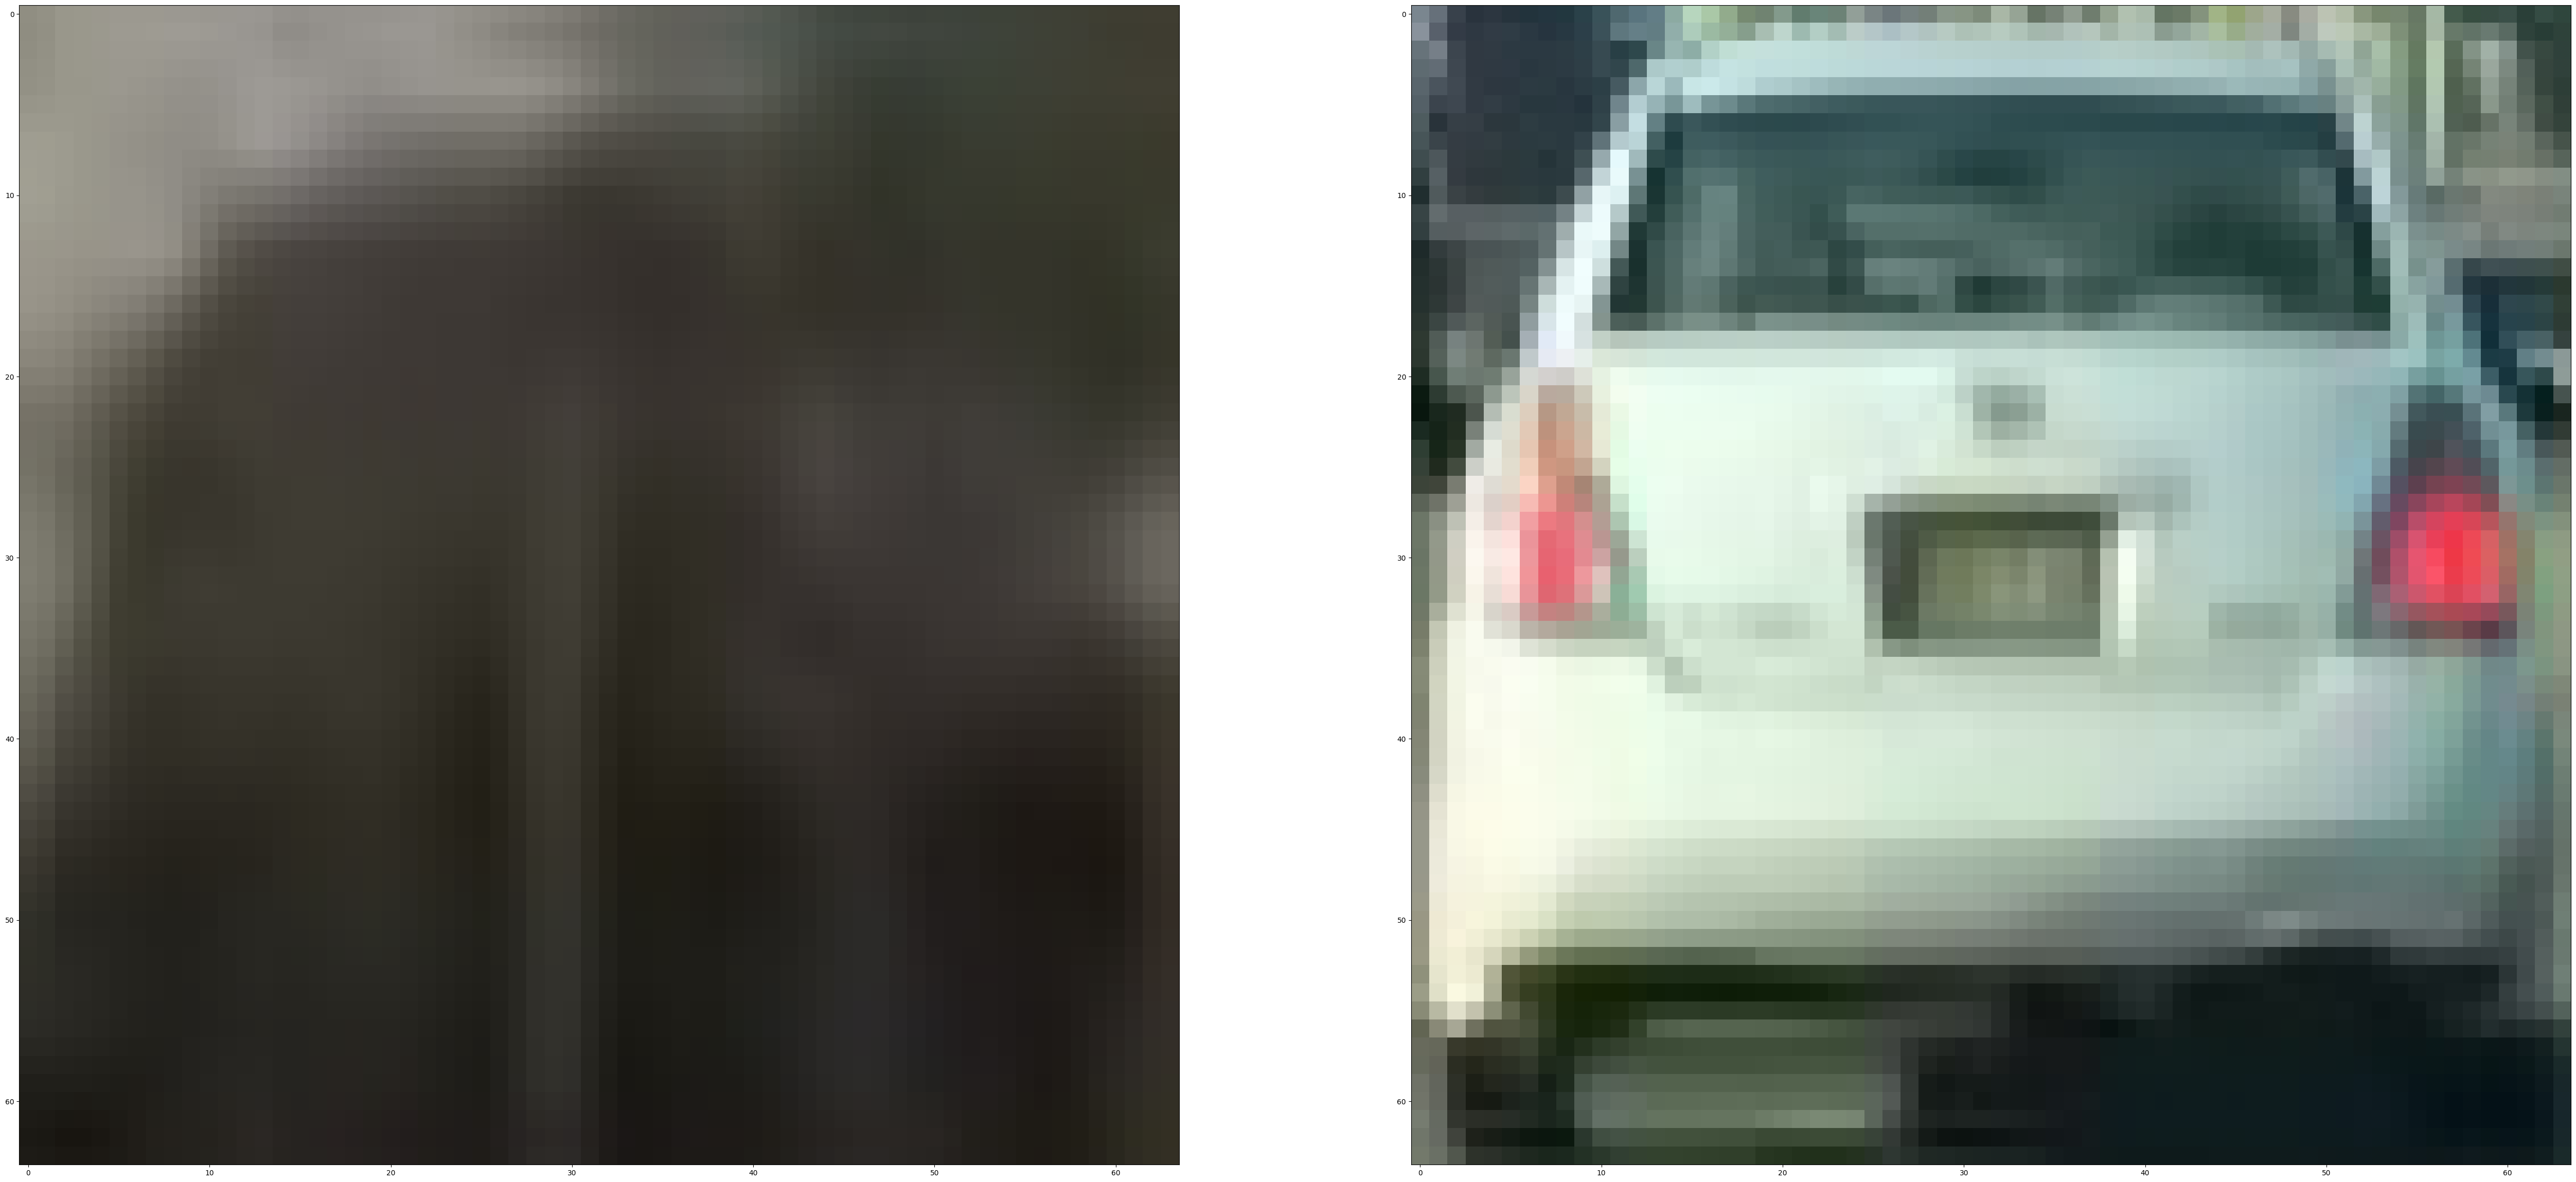

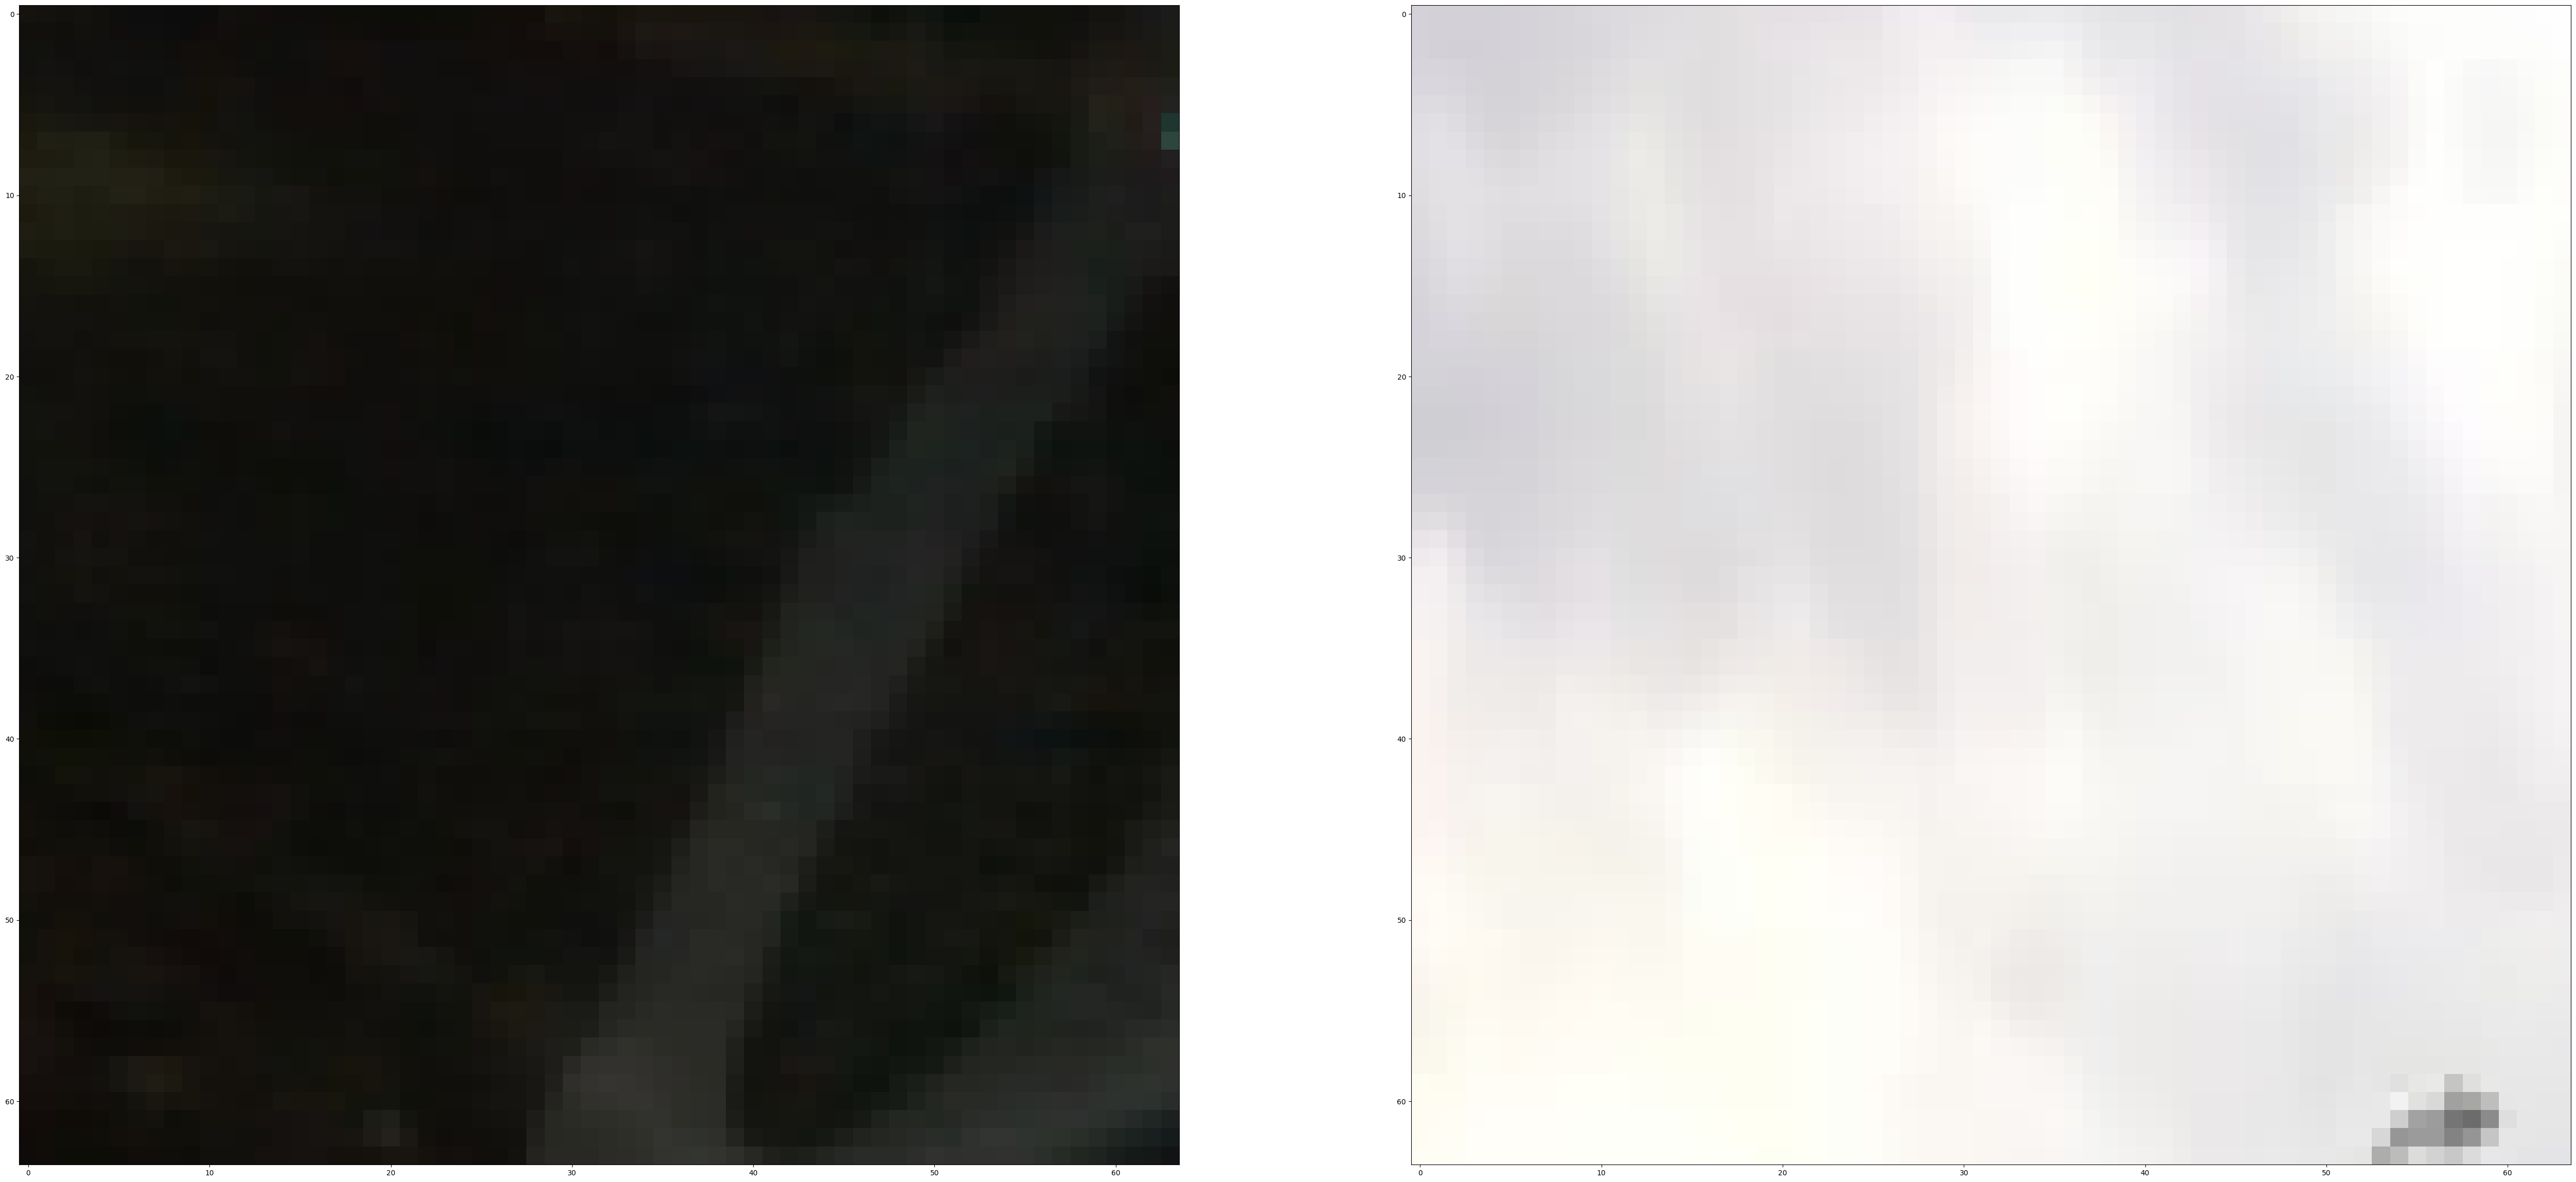

In [4]:
plt.figure(figsize=(64,64))
plt.subplot(1,2,1)
plt.imshow(images[random.randint(0, len(images)/2)])
plt.subplot(1,2,2)
plt.imshow(images[random.randint(0, len(images)/2)])
plt.show()

plt.figure(figsize=(64,64))
plt.subplot(1,2,1)
plt.imshow(images[random.randint(len(images)/2, len(images))])
plt.subplot(1,2,2)
plt.imshow(images[random.randint(len(images)/2, len(images))])
plt.show()


# Extract features

In [5]:
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': 2,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}

X = feature_from_images_pipeline(
    images,
    **spatial_bin_params, 
    **color_hist_params, 
    **hog_hist_params
)
y = labels

print(X.shape)
print(y.shape)

100%|██████████| 32036/32036 [05:34<00:00, 95.64it/s] 


(32036, 8460)
(32036,)


# Preprocess features

In [6]:
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

print(X_scaled.shape)

with open('models/classification_dataset_from_recognition_dataset_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)

(32036, 8460)


# Classification

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, random_state=42
)

svc = LinearSVC(dual='auto', max_iter=10000)
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [97]:
linear_svc_model = LinearSVC(dual='auto')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': 3000
}

grid_search = GridSearchCV(estimator=linear_svc_model, param_grid=param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-pa

KeyboardInterrupt: 

In [ ]:
with open('models/classification_dataset_from_recognition_dataset_classifier.pkl', 'wb') as file:
    pickle.dump(svc, file)